In [155]:
from tools import *
%matplotlib notebook
from astropy.io import fits
from glob import glob
from astropy.table import Table

from make_synmags import Spec_mags, mangle

from copy import deepcopy

In [ ]:
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs([], model_mags, model,SVO=True)

In [114]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("DECam/")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("Bessell/")]
norm = [x['obsmode'] for x in passbands if x['passband'].startswith("Bessell/")]
norm = norm[1:]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
model = 'Vega'
norm = source_synphot.passband.load_pbs(norm, model_mags, model)
pbnames = pbs.keys()

def Specs(Specs):
    specs = {}
    for spec in Specs:
        print(spec)
        model_sed = source_synphot.source.pre_process_source(spec,np.nan,'ps1g',0,Renorm=False)
        specs[spec] = model_sed

    return specs

def my_norm(Spec,pbs,mag):
    spec = deepcopy(Spec)
    m = Syn_mag(pbs,spec)
    m=m['besI']
    print(mag-m)
    factor = 10**(-2/5*(mag-m))
    spec = S.ArraySpectrum(wave=spec.wave,waveunits=spec.waveunits,
                                   flux=spec.flux*factor,fluxunits=spec.fluxunits)
    return spec

def Syn_mag(pbs,spec):
    mag = {}
    for pb in pbs:
        if spec is not None:
            syn_mag = source_synphot.passband.synphot(spec,pbs[pb][0],zp=pbs[pb][1])
        else:
            syn_mag = np.nan
        mag[pb] = syn_mag
        
    return mag

In [115]:
files = glob('../../data/sn/sn2011fe/11fe_snf/*')

p = []
for f in files:
    pp = f.split('fe')[-1].split('.dat')[0]
    if 'm' in pp.lower():
        p += [- float(pp.split('M')[-1])]
    else:
        p += [float(pp.split('P')[-1])]
p = np.array(p)/10
ind = np.argsort(p) 
p = p[ind]

files = np.array(files)[ind]

ind = p <0
p = p[ind]
files = files[ind]

In [116]:
lc = pd.read_csv('../../data/sn/sn2011fe/sn2011fe_dp.csv')
v = lc.iloc[lc.band.values == 'V']
b = lc.iloc[lc.band.values == 'B']
r = lc.iloc[lc.band.values == 'R']
I = lc.iloc[lc.band.values == 'I']
dist = np.zeros(len(files))
cal = np.zeros(len(files),dtype=int)
for i in range(len(p)):
    #print(np.nanmin(abs(I.time.values-p[i])))
    if np.nanmin(abs(I.time.values-p[i])) > .2:
        dist[i] = 1
    ind = np.argmin(abs(I.time.values-p[i]))
    cal[i] = ind
ii = I.iloc[cal]
cal = np.zeros(len(files),dtype=int)
for i in range(len(p)):
    #print(np.nanmin(abs(v.time.values-p[i])))
    if np.nanmin(abs(v.time.values-p[i])) > .2:
        dist[i] = 1
    ind = np.argmin(abs(v.time.values-p[i]))
    cal[i] = ind
vv = v.iloc[cal]

cal = np.zeros(len(files),dtype=int)
for i in range(len(p)):
    #print(np.nanmin(abs(b.time.values-p[i])))
    if np.nanmin(abs(b.time.values-p[i])) > .2:
        dist[i] = 1
    ind = np.argmin(abs(b.time.values-p[i]))
    cal[i] = ind
bb = b.iloc[cal]

cal = np.zeros(len(files),dtype=int)
for i in range(len(p)):
    #print(np.nanmin(abs(r.time.values-p[i])))
    if np.nanmin(abs(r.time.values-p[i])) > .2:
        dist[i] = 1
    ind = np.argmin(abs(r.time.values-p[i]))
    cal[i] = ind
rr = r.iloc[cal]
dist = dist < 1
ii = ii.iloc[dist]
vv = vv.iloc[dist]
bb = bb.iloc[dist]
rr = rr.iloc[dist]
files = files[dist]

In [117]:
def mangle(spec,pbs,mags,plot=False):
    """
    Mangle a spectrum to scale it to observed photometry.

    Inputs
    ------
        spec : pysynphot spectrum array

        pbs : ordered dict 
            dictionary of passbands. first entry is a pysynphot array passband second is the band zeropoint.
        mags : list/array
            list of magnitudes in the same order as the bands
    Options
    -------
        plot : bool
            if true, plots the scale factor

    Returns
    -------
        s : pysynphot spectrum array
            input spectrum scalled by the mangling process
    """
    scale = np.array((spec.wave,spec.flux))
    scale[1,:] = 1
    i = 0
    inds = []
    for pb in pbs:
        filt = pbs[pb]
        syn_mag = source_synphot.passband.synphot(spec,filt[0],zp=filt[1])
        factor = 10**(-2/5*(mags[i]-syn_mag))
        med_wav = np.average(filt[0].wave,weights = filt[0].throughput)
        ind = np.argmin(abs(scale[0,:] - med_wav))
        inds += [ind]
        scale[1,ind] = factor
        i += 1 
    inds.sort()
    # Scipy interpolation, more flexibility in fit
    #interp = interp1d(scale[0,inds],scale[1,inds],kind='linear',bounds_error=False,fill_value=0)
    #interped = interp(scale[0,:])
    #interped[:min(inds)] = scale[1,min(inds)]
    #interped[:max(inds)] = scale[1,max(inds)]
    
    factors = np.interp(scale[0,:],scale[0,inds],scale[1,inds])
    scale[1,:] = factors
    s = S.ArraySpectrum(spec.wave,spec.flux*scale[1,:])
    if plot:
        plt.figure()
        plt.plot(scale[0,:],factors,'.',label='Spline')
        plt.plot(scale[0,inds],factors[inds],'x',label='references')
        plt.plot(spec.wave,spec.flux/np.nanmax(spec.flux),label='original')
        plt.plot(s.wave,s.flux/np.nanmax(s.flux),label='mangled')
        plt.xlabel('Wavelength')
        plt.ylabel('normed flux/scale factor')
        plt.legend()
        plt.savefig('mangle{}.png'.format(spec))
        print('mangle{}.png'.format(spec))
    return s

In [133]:
specs = []
origs = []
global yy 
yy = 0
for i in range(len(files)):
    dat = np.loadtxt(files[i],skiprows=1)
    spec = S.ArraySpectrum(wave=dat[:,0],flux=dat[:,1],name='spec'+ str(i))
    origs += [spec]
    mags = [bb['magnitude'].values[i],vv['magnitude'].values[i],rr['magnitude'].values[i],ii['magnitude'].values[i]]
    
    specs += [mangle(spec,norm,mags,plot=False)]
    

In [146]:
ss = specs[2]
ss.convert('flam')
arr = np.zeros((len(ss.wave),2))
arr[:,0] = ss.wave
arr[:,1] = ss.flux

In [147]:
ss

In [150]:
np.savetxt('mangled_11feM122.dat',arr)

<IPython.core.display.Javascript object>


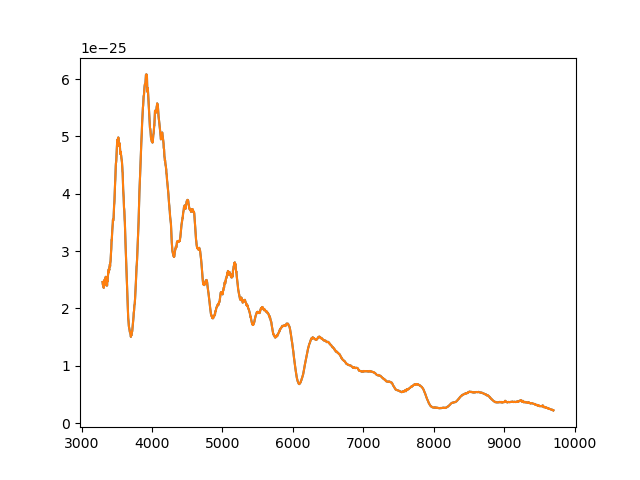

In [149]:
plt.figure()
plt.plot(arr[:,0],arr[:,1])
plt.plot(specs[2].wave,specs[2].flux)

In [118]:
thing = pd.DataFrame(Spec_mags(specs,pbs))
orig = pd.DataFrame(Spec_mags(origs,pbs))

In [119]:
p = []
for f in files:
    pp = f.split('fe')[-1].split('.dat')[0]
    if 'm' in pp.lower():
        p += [- float(pp.split('M')[-1])]
    else:
        p += [float(pp.split('P')[-1])]
p = np.array(p)

In [120]:
thing['phase'] = p/10
orig['phase'] = p/10

In [121]:
thing = thing.sort_values('phase',ignore_index=True)
orig = orig.sort_values('phase',ignore_index=True)

In [122]:
thing

,Kep,decamg,decami,besU,besB,besV,besR,besI,phase
0,13.831640,13.801773,14.165974,14.810509,13.880584,13.668247,13.811251,14.166715,-15.2
1,13.107362,13.056207,13.406632,13.997279,13.100699,12.971768,13.098167,13.404572,-14.3
2,12.143208,12.127894,12.325038,12.802584,12.117307,12.078584,12.118550,12.321188,-12.2
3,11.667382,11.569191,11.898187,12.022884,11.496240,11.608480,11.664658,11.906277,-11.3
4,11.333727,11.207831,11.553275,11.553539,11.108321,11.285620,11.342366,11.564288,-10.3
5,11.040435,10.920658,11.267164,11.141428,10.819923,10.985732,11.039669,11.282078,-9.3
6,10.835040,10.699508,11.067908,10.914412,10.590876,10.769339,10.843209,11.086322,-8.3
7,10.643720,10.497076,10.899448,10.622662,10.384550,10.575936,10.650698,10.919616,-7.2
8,10.504645,10.351330,10.787013,10.503776,10.239322,10.424306,10.510910,10.809906,-6.3
9,10.390010,10.210299,10.707426,10.351501,10.092394,10.296862,10.407096,10.730536,-5.3


In [123]:
obs_br = (bb.magnitude.values - rr.magnitude.values)
man_br = thing.besB - thing.besR
orig_br = orig.besB - orig.besR
obs_bi = (bb.magnitude.values - ii.magnitude.values)
man_bi = thing.besB - thing.besI
orig_bi = orig.besB - orig.besI

<IPython.core.display.Javascript object>


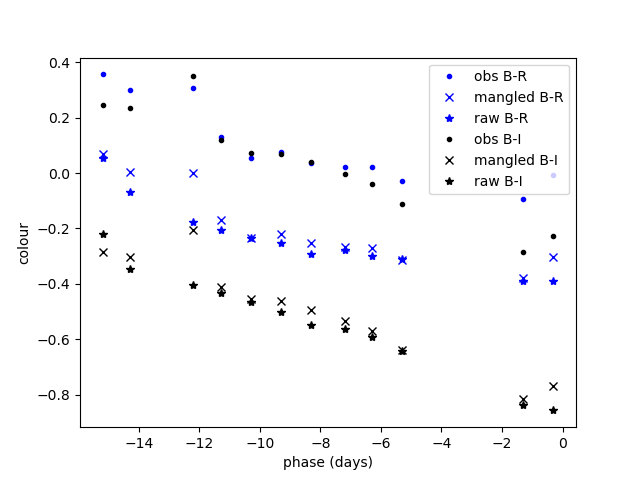

Text(0.5, 0, 'phase (days)')

In [124]:
plt.figure()
plt.plot(thing.phase,obs_br,'b.',label='obs B-R')
plt.plot(thing.phase,man_br,'bx',label='mangled B-R')
plt.plot(thing.phase,orig_br,'b*',label='raw B-R')
plt.plot(thing.phase,obs_bi,'k.',label='obs B-I')
plt.plot(thing.phase,man_bi,'kx',label='mangled B-I')
plt.plot(thing.phase,orig_bi,'k*',label='raw B-I')
plt.legend()
plt.ylabel('colour')
plt.xlabel('phase (days)')
#plt.savefig('colour_comparisons_fe_Vega.png')

<IPython.core.display.Javascript object>


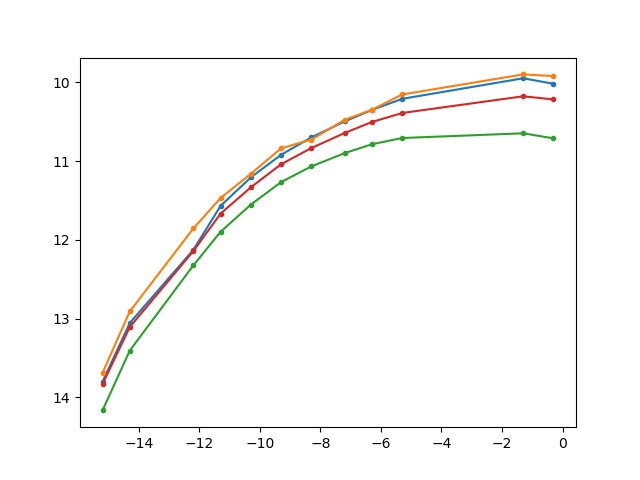

In [151]:
plt.figure()
plt.plot(thing.phase,thing.decamg,'.-')
plt.plot(orig.phase,orig.decamg,'.-')
plt.plot(thing.phase,thing.decami,'.-')
plt.plot(thing.phase,thing.Kep,'.-')
plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>


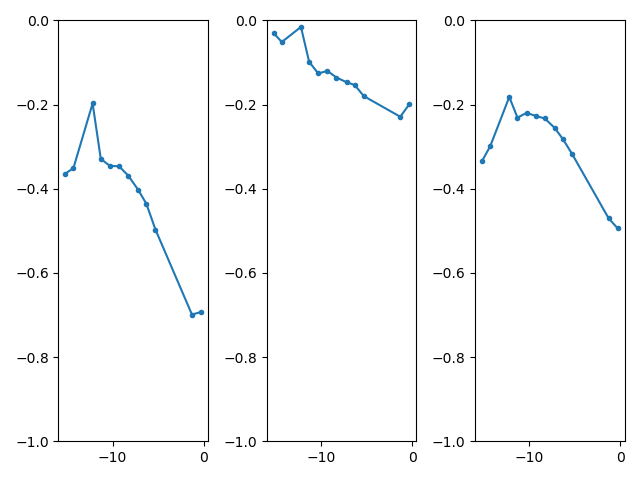

In [128]:
plt.figure()
plt.subplot(131)
plt.plot(thing.phase,thing.decamg-thing.decami,'.-')
plt.ylim(-1,0)
plt.subplot(132)
plt.plot(thing.phase,thing.decamg-thing.Kep,'.-')
plt.ylim(-1,0)
plt.subplot(133)
plt.plot(thing.phase,thing.Kep-thing.decami,'.-')
plt.ylim(-1,0)
#plt.gca().invert_yaxis()
plt.tight_layout()

In [152]:
thing = orig[['phase','decamg','decami','Kep']]

In [153]:
thing.to_csv('syn_2011fe.csv',index=False)

In [154]:
thing

,phase,decamg,decami,Kep
0,-15.2,13.689141,13.965836,13.705126
1,-14.3,12.909286,13.278210,12.988801
2,-12.2,11.856230,12.207447,11.965472
3,-11.3,11.468844,11.820170,11.586516
4,-10.3,11.161886,11.525274,11.292194
5,-9.3,10.838424,11.226944,10.978876
6,-8.3,10.727638,11.143167,10.886741
7,-7.2,10.476709,10.908455,10.633301
8,-6.3,10.348972,10.807068,10.518012
9,-5.3,10.154928,10.662559,10.335799


In [10]:
lc = pd.read_csv('../../data/sn/sn2011fe/sn2011fe_dp.csv')
v = lc.iloc[lc.band.values == 'V']
b = lc.iloc[lc.band.values == 'B']
r = lc.iloc[lc.band.values == 'R']
I = lc.iloc[lc.band.values == 'I']

<IPython.core.display.Javascript object>


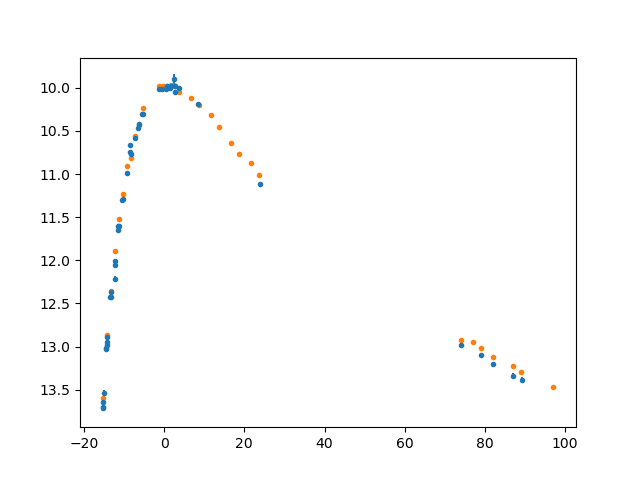

In [47]:
plt.figure()
plt.errorbar(v.time,v.magnitude,v.e_magnitude,fmt='.')
#plt.plot(b.time,b.magnitude,'.')

plt.plot(thing.phase,thing.V,'.')

plt.gca().invert_yaxis()

#for t in thing.phase.values:
#    plt.axvline(t)

,event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
4,SN2011fe,-15.3640,13.704,0.037,F,V,UVOT,Swift,2014Ap&SS.354...89B
10,SN2011fe,-15.3400,13.714,0.022,F,V,NaN,kait4,"2019MNRAS.490.3882S,2012MNRAS.425.1789S"
18,SN2011fe,-15.2865,13.638,0.036,F,V,UVOT,Swift,2014Ap&SS.354...89B
26,SN2011fe,-15.0963,13.543,0.035,F,V,UVOT,Swift,2014Ap&SS.354...89B
32,SN2011fe,-14.4281,13.021,0.032,F,V,UVOT,Swift,2014Ap&SS.354...89B
37,SN2011fe,-14.4200,13.025,0.013,F,V,NaN,NaN,"2012JAVSO..40..872R,Sternberg Astronomical Ins..."
41,SN2011fe,-14.3300,12.977,0.016,F,V,NaN,kait4,"2019MNRAS.490.3882S,2012MNRAS.425.1789S"
47,SN2011fe,-14.2916,12.951,0.032,F,V,UVOT,Swift,2014Ap&SS.354...89B
55,SN2011fe,-14.1564,12.893,0.031,F,V,UVOT,Swift,2014Ap&SS.354...89B
62,SN2011fe,-13.4200,12.420,0.020,F,V,NaN,NaN,"2012JAVSO..40..872R,Sternberg Astronomical Ins..."


In [49]:
files.sort()

In [61]:
files

array(['../../data/sn/sn2011fe/11fe_snf/11feM152.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM143.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM133.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM122.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM113.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM103.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM093.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM083.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM072.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM063.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM053.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM013.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feM003.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feP007.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feP017.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feP027.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feP037.dat',
       '../../data/sn/sn2011fe/11fe_snf/11feP067.dat',
       '..